# Energy systems optimisation models for Life Cycle Assessment : 
# a dwelling photovoltaic system study case using NoLOAD


- **Study context** : This notebook presents a dwelling PV self-consumption use case from an early stage design perspective. We carry out a two-objective optimisation in order to maximise the coverage of local consumption by photovoltaic electricity on the one hand, and to minimise the environmental impact of the energy system over its entire life cycle on the other hand.
The study focuses on one single representative building with PV panels and battery storage within the framework of a self-consumption operation. At the moment, it does not explore other relevant means to improve self-consumption rates, such as Demand Side Management, or other storage technologies ranging from other battery chemistries, to hydrogen for inter-seasonal storage, to heat storage.  
- **Licence** : [Apache 2.0](https://www.apache.org/licenses/LICENSE-2.0.html), Copyright 2018 G2Elab / MAGE
- **References** : [Open and Reproducible Use Cases in the Energy field for systems design and operation: a dwelling photovoltaic self-consumption example](https://hal.archives-ouvertes.fr/hal-03341883)
- **Tool** : [NoLOAD](https://gricad-gitlab.univ-grenoble-alpes.fr/design_optimization/noload), version 1.2.4, licence Apache 2.0. It is a non-linear optimization tool for energy system and components.   
- **Developer - institution** : Sacha Hodencq (sacha.hodencq@g2elab.grenoble-inp.fr) - G2Elab   

>***First time using a Jupyter Notebook ?*** In order to use this notebook online through the Mybinder public service, click the following icon  
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgricad-gitlab.univ-grenoble-alpes.fr%2Fdesign_optimization%2Fnoload_benchmarks_open/HEAD?filepath=%2Fexamples%2Fpv_battery_coverage_gwp%2Fpv_battery_coverage_gwp.ipynb)  
>You can then easily use this Jupyter notebook by runnning each cell with the Run (\"Exécuter\" in French) icon in the toolbar on top of the page. When the orange notebook icon in the tab turns into an hourglass, this means the code is still running. Do not hesitate to modify and adapt the code, working with Mybinder creates an online copy of the repository ipynb original file."

We present the study case of a dwelling self-consumption of photovoltaic (PV) energy with battery storage. 
Increasing the share of renewable energy in our energy consumption as well as improving energy efficiency and reducing our total energy consumption have been identified as the main solutions for a viable energy transition.  
PV self-consumption can reduce the impact of PV on the power grid and so improve PV overall grid penetration. The question we ask ourselves here is the one of the environmental impact of PV self-consumption. In other words, **how to compromise between high PV self-consumption rates and low energy system environmental impacts ?**
Here we will only focus on the the Global Warming Potential (GWP) of the energy system over its all lifecycle.

## 1. Input data and modelling hypotheses

#### Relevant libraries import

In [7]:
%matplotlib inline
# %matplotlib notebook
# direct display in the notebook

import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from data.data_management import read_data, load_consumption_index, load_irradiance_index, extract_csv_from_mhi, get_data
from data.enedis_apis import coefficient_des_profils
from data.clustering import clustering
from data import clustering_sk
from sklearn.metrics import pairwise_distances_argmin_min
import warnings
from datetime import timedelta as td
# from tabulate import tabulate
from datetime import datetime
# from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import models.solarPV as solarPV
import matplotlib.pyplot as plt

from noload.optimization.optimProblem import Spec, OptimProblem
import models.model as model
from optim.optim_definition import plot_results
from noload.optimization.optimProblem import Spec, OptimProblem
import noload.gui.plotPareto as pp

<a id='data-management-from-csv-file'></a>
#### Data management from csv file
A local version of the data sets is available, in case the data base is unavailable or updated. It is imported with the function *read_data*, and is used in the current version of the notebook, due to a data base update.

In [8]:
# Data
yearly_data = read_data(file_name='./data/irradiance_and_consumption_data.csv')
yearly_irradiance = yearly_data[0]
yearly_consumption = yearly_data[1].values[:, 0]
print('Annual consumption of a single dwelling= {} kWh'.format(round(sum(yearly_consumption)/1e3)))

Annual consumption of a single dwelling= 4453 kWh


C:\Users\hodencqs\Anaconda3\envs\noload_lab\lib\site-packages\scipy\cluster\vq.py:136: RuntimeWarning: Some columns have standard deviation zero. The values of these columns will not change.
  warnings.warn("Some columns have standard deviation zero. "


Number of days in each cluster
[ 50 182 133]
Indices of days close to the cluster center
[  3 240 330]


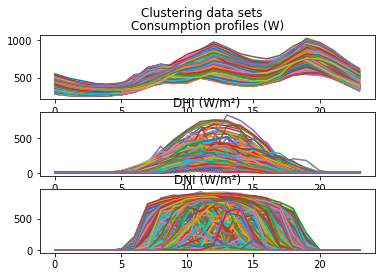

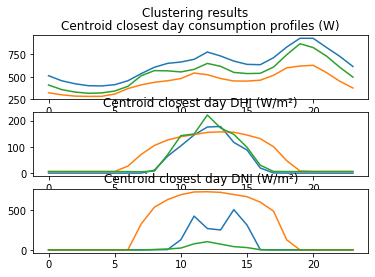

(array([ 50, 182, 133], dtype=int64), array([  3, 240, 330], dtype=int64))

In [9]:
# Clustering
clustering('./data/irradiance_and_consumption_data.csv', 3, True)

Days 3, 240 and 330 correspond to the 4th of January, the 29th of August and the 27th of November. We recognise typical winter, summer, and mid-season days.

### Energy model

![NoLOAD_PV](https://gricad-gitlab.univ-grenoble-alpes.fr/design_optimization/noload_benchmarks_open/-/raw/master/examples/pv_battery_coverage_gwp/figures/dwelling_pv_self_consumption.png)

The energy model is a simplified one where the main variables and parameters consist in:
- pv_power (W): the power produced by the pv pannels depending on the irradiance values (W/m²) as well as the tilt (degree), azimuth (degree) and surface (m²) of the pannels. It is defined in the solarPV model.
- consumption (W): the consumption of the dwelling
- e_sto (Wh): the charged energy for export calculation, or discharged energy for import calculation
- import (Wh): the energy imported from the power grid, defined as the energy that is not self produced by the PV-batteries system.
- export (Wh): the energy exported to the power grid, defined as the energy that is not self-consumed by the PV-batteries system.

Energy import, export, pv_power and consumption are illustrated hereunder without the battery consideration:


In [10]:
# A PV power profile example...
tilt = 25
azimuth = 0
surface = 8

In [11]:
summer_consumption = [yearly_consumption[h] for h in range(24*240,24*241)]
winter_consumption = [yearly_consumption[h] for h in range(24*3,24*4)]
mid_consumption = [yearly_consumption[h] for h in range(24*330,24*331)]

summer_irradiance = yearly_irradiance.iloc[24*240:24*241]
winter_irradiance = yearly_irradiance.iloc[24*3:24*4]
mid_irradiance = yearly_irradiance.iloc[24*330:24*331]

*NB: in this whole study, the tilt and azimuth are constant: no solar tracker is considered.*

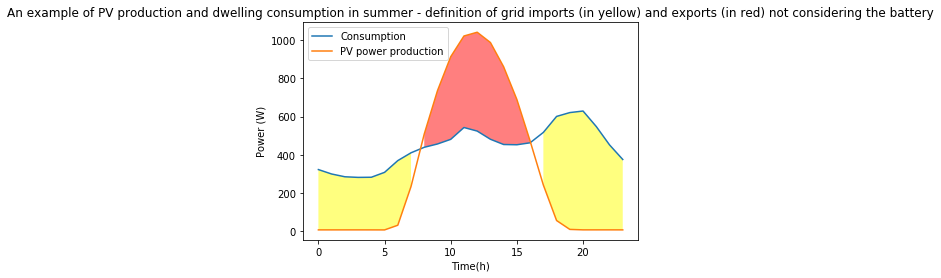

In [12]:
# # on the 29th of August 
solar_summer = solarPV.PVSolar(summer_irradiance.index.to_series())
DNI_summer = np.array(summer_irradiance['DNI'])
DHI_summer = np.array(summer_irradiance['DHI'])

pv_power_summer = solar_summer.pv_power(tilt, azimuth, surface, DNI_summer, 
                                        DHI_summer)

fig2, ax2 = plt.subplots()  
ax2.plot(summer_consumption, label='Consumption') 
ax2.plot(pv_power_summer, label='PV power production') 

plt.fill_between(np.arange(0,24), pv_power_summer, summer_consumption, 
                 where=summer_consumption >= pv_power_summer, 
                 facecolor='yellow', alpha=0.5)
plt.fill_between(np.arange(0,24), pv_power_summer, summer_consumption, 
                 where=pv_power_summer >= summer_consumption, facecolor='red', alpha=0.5)
ax2.set_xlabel('Time(h)')  
ax2.set_ylabel('Power (W)')  
ax2.set_title('An example of PV production and dwelling consumption '
              'in summer - '
              'definition of grid imports (in yellow) and exports (in red) not considering the battery')
ax2.legend()  

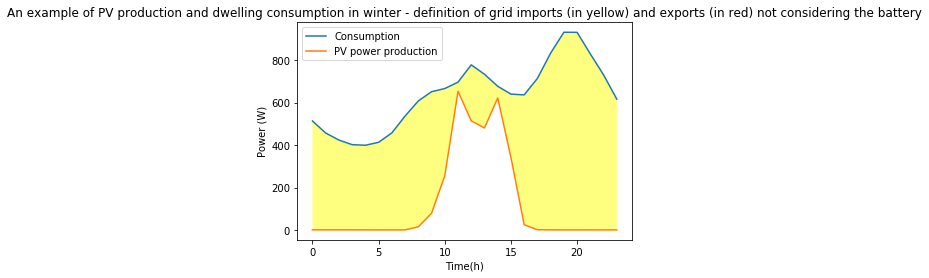

In [13]:
# ... in winter
solar_winter = solarPV.PVSolar(winter_irradiance.index.to_series())
DNI_winter = np.array(winter_irradiance['DNI'])
DHI_winter = np.array(winter_irradiance['DHI'])
pv_power_winter = solar_winter.pv_power(tilt, azimuth, surface, DNI_winter, 
                                        DHI_winter)

fig3, ax3 = plt.subplots()  
ax3.plot(winter_consumption, label='Consumption') 
ax3.plot(pv_power_winter, label='PV power production') 
plt.fill_between(np.arange(0,24), pv_power_winter, winter_consumption, 
                 where=winter_consumption >= pv_power_winter, 
                 facecolor='yellow', alpha=0.5)
plt.fill_between(np.arange(0,24), pv_power_winter, winter_consumption, 
                 where=pv_power_winter >= winter_consumption, facecolor='red', 
                 alpha=0.5)
ax3.set_xlabel('Time(h)')  
ax3.set_ylabel('Power (W)')  
ax3.set_title('An example of PV production and dwelling consumption '
              'in winter - '
              'definition of grid imports (in yellow) and exports (in red) not considering the battery')
ax3.legend()  

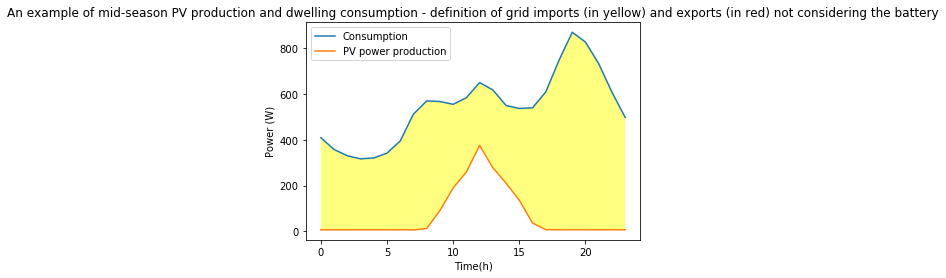

In [14]:
# ... in mid-season
solar_mid = solarPV.PVSolar(mid_irradiance.index.to_series())
DNI_mid = np.array(mid_irradiance['DNI'])
DHI_mid = np.array(mid_irradiance['DHI'])
pv_power_mid = solar_winter.pv_power(tilt, azimuth, surface, DNI_mid, 
                                        DHI_mid)

fig3, ax3 = plt.subplots()  
ax3.plot(mid_consumption, label='Consumption') 
ax3.plot(pv_power_mid, label='PV power production') 
plt.fill_between(np.arange(0,24), pv_power_mid, mid_consumption, 
                 where=mid_consumption >= pv_power_mid, 
                 facecolor='yellow', alpha=0.5)
plt.fill_between(np.arange(0,24), pv_power_mid, mid_consumption, 
                 where=pv_power_mid >= mid_consumption, facecolor='red', 
                 alpha=0.5)
ax3.set_xlabel('Time(h)')  
ax3.set_ylabel('Power (W)')  
ax3.set_title('An example of mid-season PV production and dwelling consumption - '             
              'definition of grid imports (in yellow) and exports (in red) not considering the battery')
ax3.legend()  

In [15]:
# Clustering verification

# Consumption
cluster_cons = (sum(summer_consumption)*180+sum(winter_consumption)*50+sum(mid_consumption)*135)/1000
original_cons = sum(yearly_consumption)/1000
print("Consommation annuelle clustering : {0}kWh, données originales : {1}kWh. Différence relative : {2}%".format(round(cluster_cons,2),round(original_cons,2), round((original_cons-cluster_cons)/original_cons*100,2)))

# PV production
solar_year = solarPV.PVSolar(yearly_irradiance.index.to_series())
DNI_year = np.array(yearly_irradiance['DNI'])
DHI_year = np.array(yearly_irradiance['DHI'])

pv_power_year = solar_year.pv_power(tilt, azimuth, surface, DNI_year, DHI_year)

cluster_prod = (sum(pv_power_summer)*180+sum(pv_power_winter)*50+sum(pv_power_mid)*135)/1000
original_prod = sum(pv_power_year)/1000

print("Production PV annuelle clustering : {0}kWh, données originales : {1}kWh (pour surface-tilt_azimuth = {2}). Différence relative : {3}%".format(round(cluster_prod,2),round(original_prod,2),(surface,tilt,azimuth) ,round((cluster_prod-original_prod)/original_prod*100,2)))


Consommation annuelle clustering : 4434.74kWh, données originales : 4453.07kWh. Différence relative : 0.41%
Production PV annuelle clustering : 1798.52kWh, données originales : 1737.85kWh (pour surface-tilt_azimuth = (8, 25, 0)). Différence relative : 3.49%


Text(0, 0.5, 'PV production (W/m²)')

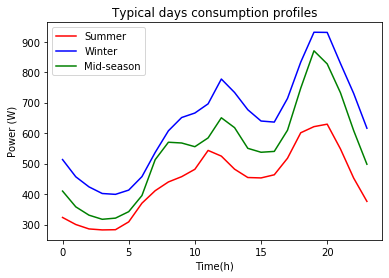

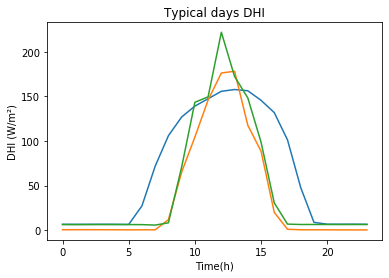

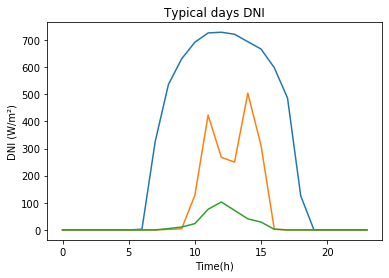

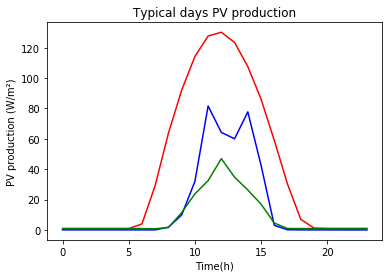

In [16]:
# Plotting these figures ?
plt.figure(0)
plt.plot(summer_consumption, "-r", label="Summer")
plt.plot(winter_consumption, "-b", label="Winter")
plt.plot(mid_consumption, "-g", label="Mid-season")
plt.title('Typical days consumption profiles')
plt.xlabel('Time(h)')
plt.ylabel('Power (W)')
plt.legend()

plt.figure(1)
plt.plot(summer_irradiance['DHI'].values)
plt.plot(winter_irradiance['DHI'].values)
plt.plot(mid_irradiance['DHI'].values)
plt.title('Typical days DHI')
plt.xlabel('Time(h)')
plt.ylabel('DHI (W/m²)')

plt.figure(2)
plt.plot(summer_irradiance['DNI'].values)
plt.plot(winter_irradiance['DNI'].values)
plt.plot(mid_irradiance['DNI'].values)
plt.title('Typical days DNI')
plt.xlabel('Time(h)')
plt.ylabel('DNI (W/m²)')

plt.figure(3)
plt.plot([ps/surface for ps in pv_power_summer], "-r")
plt.plot([pw/surface for pw in pv_power_winter], "-b")
plt.plot([pm/surface for pm in pv_power_mid], "-g")
plt.title('Typical days PV production')
plt.xlabel('Time(h)')
plt.ylabel('PV production (W/m²)')


Then, what are going to be optimisation objectives can be defined: the Load Cover Factor (LCF) and Supply Cover Factor (SCF) can be relevant indicators:
- SCF: the percentage of the on-site generation that is used by the building. 

- LCF: the percentage of the electrical demand covered by on-site electricity generation. 

In our case, they can be calculated for each typical day as follow:
$$ SCF = \frac{E_{PV}-exports}{E_{PV}} $$
$$ LCF = \frac{E_{load}-imports}{E_{load}} $$

with E_PV and E_load respectively the energy in Watt-hours produced by the PV panels and consumed by the household during one day. Using both the LCF and SCF makes it possible to jointly minimise the household electricity exports and imports, sizing the PV system and the battery as close as possible to the needs, thus making the dwelling as imperceptible as possible from the grid point of view. 

In the case presented hereinbefore for instance:

In [15]:
e_sto = 1000  # value for the stored energy (Wh)
eff_sto_lead_acid = 0.75  # efficacity of the lead-acid battery
eff_sto_li_ion = 0.86  #  Round-trip storage efficiency - Source : https://ease-storage.eu/energy-storage/technologies/ 

e_balance_vect = pv_power_summer - summer_consumption

# energy imported and exported, depending on hourly balance, and the total
# battery energy charged/discharged, taking into account the storage
# efficiency.
energy_import = -np.sum(e_balance_vect[e_balance_vect < 0]) - eff_sto_li_ion * e_sto
energy_export = np.sum(e_balance_vect[e_balance_vect > 0]) - eff_sto_li_ion * e_sto

pv_supply = pv_power_summer.sum()  # PV energy
load = sum(summer_consumption)  # Load energy
e_balance = np.sum(e_balance_vect)
coverage = pv_supply - energy_export
# checking the definition with another one :
coverage2 = load - energy_import
assert (abs(coverage - coverage2) < 1e-5)
# defining the cover factors, between 1 and 0 :
supply_cover_factor = coverage / pv_supply
load_cover_factor = coverage / load

print('The supply cover factor is {0} and the load cover factor is {1} for this summer day example.'.format(round(supply_cover_factor, 2), round(load_cover_factor,2)))

The supply cover factor is 0.74 and the load cover factor is 0.55 for this summer day example.


The storage energy values (e_sto) in the various typical days corresponds to the battery charge for export calculations, and discharged for export calculations. The battery actual capacity is the maximum between these values, and it takes into account state of charge actual limitations.   

For monoobjective optimisation (minimisation), a non-coverage indicator can be used, taking into account both the SCF and LCF. So doing, the PV and batteries are not oversized and the PV integration is as transparent as possible from a power grid point of view. The non-coverage indicator is defined as follows:  
$$ non-coverage = \sum_{0 \leqslant d < nb_days} \frac{w_d}{365} * \frac{(1-LCF_d)+(1-SCF_d)}{2} $$
Where : 
- nb_days is the number of typical days
- w_d is the weight of each typical day
- LCF_d is the load cover factor for a given typical day
- SCF_d is the supply cover factor for a given typical day  

*NB*: non-LCF and non-SCF indicators are defined the same way with typical day weights, and can be used as objectives.

### Life Cycle Analysis (LCA)
The LCA considerations on this study case are limited to the single environmental impact of Global Warming Potential (eq kgCO2), considered on the whole life cycle.  
**Functional unit**: consuming electricity according to a given consumption profile for 30 years with a 4586 kWh yearly consumption, from power grid and PV-battery system electricity.  
The values presented hereunder for the energy components are coming from minsterial data sets for [mono-crystalline PV](https://www.base-inies.fr/iniesV4/dist/consultation.html?id=8519) and [lead-acid batteries](https://www.base-inies.fr/iniesV4/dist/consultation.html?id=5638). The CO2 emissions from the French power grid come from the [ADEME online database](http://bilans-ges.ademe.fr/) and are related to the 2018 consumption mean value, and the ones from the european power grid can be found on the [EEA webiste](https://www.eea.europa.eu/data-and-maps/daviz/co2-emission-intensity-5#tab-googlechartid_chart_11_filters=%7B%22rowFilters%22%3A%7B%7D%3B%22columnFilters%22%3A%7B%22pre_config_ugeo%22%3A%5B%22European%20Union%20(current%20composition)%22%5D%7D%7D).

In [16]:
pv_gwp_raw = 1040  # for 6.67m² - 1kWp, monocristalline silicon 30 years lifespan
battery_lead_acid_gwp_raw = 351  # Lead-acid battery [capacity=200Ah], 38.6kg
battery_li_ion_gwp_raw = 158  # Li-ion battery [capacity=1kWh]
battery_lead_acid_lifespan = 3  # Lead-acid battery lifespan
battery_li_ion_lifespan = 8  
dod_lead_acid = 0.5  # depth of discharge lead-acid = 50%
dod_li_ion = 0.8
# french electricity mix, consumption mean value, http://bilans-ges.ademe.fr/ 2018
french_power_grid_emissions = 0.0571  # (kgCO2eq / kWh) 
# european electricity mix, data from EEA 2019 https://www.eea.europa.eu/ims/greenhouse-gas-emission-intensity-of-1 
european_power_grid_emissions = 0.250

study_time = 30  # years

# Applying coefficients to abide by the functional unit
pv_gwp = pv_gwp_raw / 6.67 * 1  # 1kWp => 1 m² , 30 years
battery_lead_acid_gwp = battery_lead_acid_gwp_raw / (200 * 12) * study_time/battery_lead_acid_lifespan  # 200Ah, 12V, 3 years => 1000 Wh, 30 years
battery_li_ion_gwp = battery_li_ion_gwp_raw/1000 * study_time/battery_li_ion_lifespan  # 8 years => 1000 Wh, 30 years


The Global Warming Potential (GWP) of the system will then be calculated as follow:  
$$ GWP\;(kg CO_2 eq)= GWP_{PV}\;(kg CO_2 eq/m²) * area_{PV}\;(m²) + GWP_{battery}\;(kg CO_2 eq/Wh) * capacity\:battery\;(Wh)+ French\:power\:grid\:emissions\:(kg CO_2 eq/kWh) * import\:grid\;(kWh\:over\:a\:year) * study\:time\ (years) $$  

The photovoltaic pannels and battery GWP factors take into account these equipments lifespan.  

Calculation example with the previously used values:

In [17]:
sum_nrj_balance_vect = pv_power_winter - summer_consumption
win_nrj_balance_vect = pv_power_winter - winter_consumption
mid_nrj_balance_vect = pv_power_mid - mid_consumption

# daily energy imports
sum_nrj_import = -np.sum(sum_nrj_balance_vect[sum_nrj_balance_vect < 0]) - e_sto
win_nrj_import = -np.sum(win_nrj_balance_vect[win_nrj_balance_vect < 0]) - e_sto
mid_nrj_import = -np.sum(mid_nrj_balance_vect[mid_nrj_balance_vect < 0]) - e_sto

capa_bat = e_sto / dod_li_ion 
# weight of typical days: 
typical_day_nb = 3
typical_day_weight = [50, 180, 135]
typical_day_indice = [3, 240, 330]
import_list = [win_nrj_import, sum_nrj_import, mid_nrj_import]

# electricity imported from the grid over a year (kWh) 
grid_import = 0
for d in range(0, typical_day_nb):
    grid_import += typical_day_weight[d] * (import_list[d]) * 0.001  # kWh

GWP = pv_gwp * surface + battery_li_ion_gwp * capa_bat + french_power_grid_emissions * grid_import * study_time
print('Global Warming Potential = {0} eq kg CO2 for an energy import of {1} kWh/y over 30 years'.format(round(GWP,2), round(grid_import,2)))

Global Warming Potential = 7472.44 eq kg CO2 for an energy import of 3201.66 kWh/y over 30 years


Before running the optimisation, we can ask ourselves what would be the GHG emissions for a consumption provided from the grid only ?

In [18]:
grid_only_emissions = cluster_cons*french_power_grid_emissions* study_time
print('grid only emissions = {0} eq kg CO2 for a consumption of {1} kWh/y over 30 years'.format(round(grid_only_emissions,2), round(cluster_cons,2)))

grid only emissions = 7596.71 eq kg CO2 for a consumption of 4434.74 kWh/y over 30 years


## 2. Optimisation problem

A bi-objective optimisation can be performed in order to maximise the local energy coverage while minimising the Global Warming Potential of the PV modules, battery and inverter over 30 years on the European power grid, and on their whole life cycle.  

### Optimisation problem definition

In order to define the optimisation problem, you first need the parameters required for the model computation, already defined hereinbefore: typical days irradiances and consumption profiles.  
Then you need to define optimisation variables as well as their bounds and initial values:
- The PV pannels
  - surface,
  - tilt
  - azimuth
- The energy of the storage for each typical day

In [19]:
cons_list = load_consumption_index(
            './data/irradiance_and_consumption_data.csv', typical_day_indice)
irr_list = load_irradiance_index(
            './data/irradiance_and_consumption_data.csv', typical_day_indice)

# creating parameters required for the model computation :
inputs = {'irradiance_list': irr_list,
          'consumption_list': cons_list,
          'typical_day_nb': typical_day_nb,
          'typical_day_weight': typical_day_weight}

# defining optimisation variables
x_names = ['surface', 'tilt', 'azimuth', 'e_sto_1', 'e_sto_2',
                   'e_sto_3']  # variables to optimize

# defining optimisation bounds
e_sto_max = 4000  # capacity below 10 kWh
pv_area_min = 1  # PV area above 20 m² since mono-objective optimisation gives a 20m² result
pv_area_max = 25  # PV area below 80 m²
bounds = [[pv_area_min, pv_area_max], [0, 90], [-80, 80], [0, e_sto_max],
          [0, e_sto_max], [0, e_sto_max]]

# initial values
e_sto_0_value = 1000  # initial capacity value
pv_area_0 = 10
tilt_0 = 45
azimuth_0 = 0
x0 = [pv_area_0, tilt_0, azimuth_0, e_sto_0_value, e_sto_0_value,
      e_sto_0_value]

The optimisation problem can then be created with **NoLOAD**.  
The objective needs to be chosen, i.e. the value to minimise in the optimisation. It can be either the non-coverage (`non_coverage`), non-scf (`non_scf`), non-lcf (`non_lcf`), or the Global Warming Potential (`gwp`).

In [20]:
objectives = ['non_lcf']

In [21]:
# imports and exports mathematically positive or null
ineq_bounds = [[0, None], [0, None], [0, None], [0, None], [0, None],
               [0, None]]

spec = Spec(variables=x_names, bounds=bounds, xinit=x0,
             objectives=objectives,
             ineq_cstr=['import_0', 'import_1',
                        'import_2', 'export_0',
                        'export_1', 'export_2'],
             ineq_cstr_bnd=ineq_bounds)


# define the optimisation
optim = OptimProblem(model=model.objectives_and_constraints,
                     specifications=spec, parameters=inputs)

Once defined, you can run the optimisation with relevant parameters:

In [22]:
ftol=1e-12  # float, Precision goal for the value of f in the stopping criterion.
maxiter=500  # int, maximum number of iteration

### Optimisation solution and results

In [21]:
result = optim.run(ftol=ftol, maxiter=maxiter)
[surface, tilt, azimuth, e_sto_1, e_sto_2, e_sto_3] = optim.wrapper.solution()   

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4775969301558854
            Iterations: 188
            Function evaluations: 634
            Gradient evaluations: 188


{'surface': 21.0, 'tilt': 26.27243531077003, 'azimuth': 27.987713643739024, 'e_sto_1': 1999.9999999999943, 'e_sto_2': 2000.0, 'e_sto_3': 422.0605663116043}
{'non_lcf': 0.4775969301558854, 'import_0': 9070.072435904185, 'import_1': 3133.866206263536, 'import_2': 8840.716734332798, 'export_0': 1831.211258214821, 'export_1': 13356.54671293773, 'export_2': 8.29913915367797e-12}
tilt   	 = 26.27243531077003
azimuth   	 = 27.987713643739024
surface   	 = 21.0
e_sto_1   	 = 1999.9999999999943
e_sto_2   	 = 2000.0
e_sto_3   	 = 422.0605663116043
typical_day_nb   	 = 3
typical_day_weight   	 = [50, 180, 135]
nrj   	 = <module 'models.energy' from 'D:\\00 - Eco-SESA\\02 - Outils\\NoLOAD\\noload_benchmarks_open\\examples\\pv_battery_coverage_gwp\\models\\energy.py'>
scf_list   	 = [0.7719503402238495, 0.35877001670907527, 0.999999999999998]
lcf_list   	 = [0.40597114686801905, 0.704544358886111, 0.3226709522237104]
import_list   	 = [9070.072435904185, 3133.866206263536, 8840.716734332798]
export

<IPython.core.display.Javascript object>


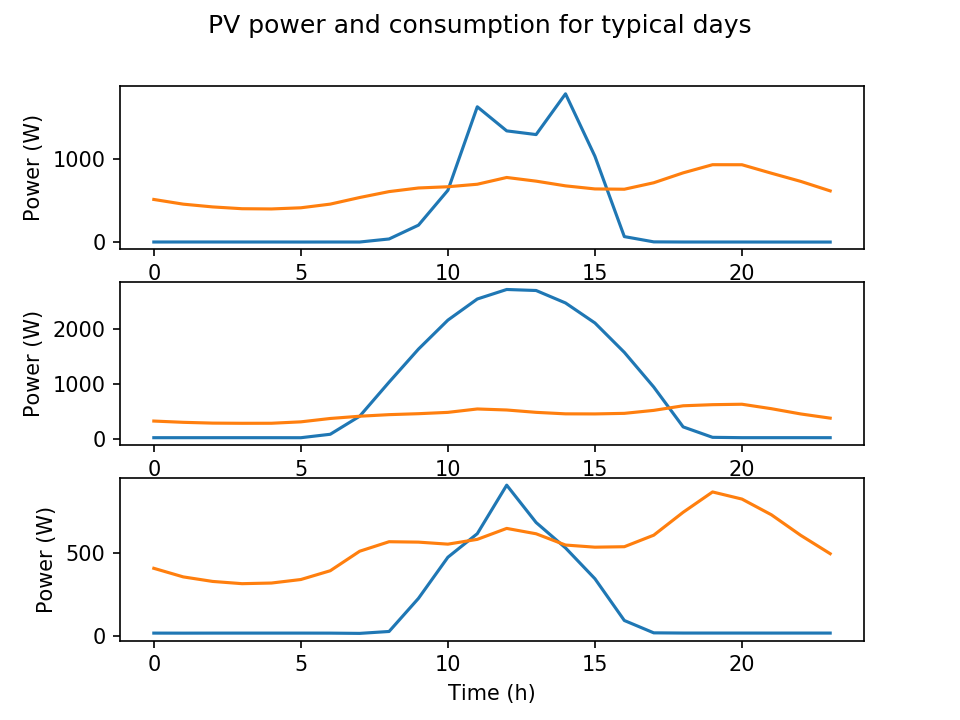

Results for each typical day with (surface, tilt, azimuth) = (21.0, 26.27, 27.99)


In [22]:
# print results
result.printResults()
for name, value in result.rawResults.items():
    if not (('irradiance' in name) or ('consumption' in name)):
        print(name, '  \t =', value)

plot_results(surface=surface, tilt=tilt, azimuth=azimuth,
                             irradiance_list=irr_list, consumption_list=cons_list, 
                             typical_day_nb=typical_day_nb)
sta = [round(value,2) for value in [surface, tilt, azimuth]]
print('Results for each typical day with (surface, tilt, azimuth) = ({0}, {1}, {2})'.format(*sta))

### Pareto
Generally speaking, the GWP objective takes into account the environmental impact of the PV panels and batteries compared to grid electricity emissions in the system sizing: it is complementary to the sole LCF objective that tends to maximise PV and battery sizing for local energy coverage. As a result, LCF and GWP will be the two objective used in the following Pareto. The SCF and non-coverage indicators can still be used alternative studies.

In [23]:
pareto_objectives = ['non_lcf', 'gwp']

spec = Spec(variables=x_names, bounds=bounds, xinit=x0,
             objectives=pareto_objectives,
             ineq_cstr=['import_0', 'import_1',
                        'import_2', 'export_0',
                        'export_1', 'export_2'],
             ineq_cstr_bnd=ineq_bounds)

# New maximal capacity definition
e_sto_max = 4000
pv_area_max = 25  # PV area below 25 m²
spec.bounds[0] = [pv_area_min, pv_area_max]
spec.bounds[3] = [0, e_sto_max]
spec.bounds[4] = [0, e_sto_max]
spec.bounds[5] = [0, e_sto_max]

# define the optimisation
optimPareto = OptimProblem(model=model.objectives_and_constraints,
                           specifications=spec, parameters=inputs)

# Number of points in the Pareto
nbParetoPts = 6

In [24]:
resultPareto = optimPareto.run(ftol=ftol, maxiter=maxiter, nbParetoPts=nbParetoPts)
resultPareto.printResults()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.35322413694059374
            Iterations: 113
            Function evaluations: 286
            Gradient evaluations: 113
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6612.1642528208595
            Iterations: 104
            Function evaluations: 264
            Gradient evaluations: 102
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10569.535673813272
            Iterations: 116
            Function evaluations: 383
            Gradient evaluations: 115
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7369.054633668139
            Iterations: 267
            Function evaluations: 693
            Gradient evaluations: 267
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.40962628638935517
            Iterations: 356
          

The convergence can be tough, depending on the tolerance (ftol<1e-8) and the number of iteration (maxiter>200). Pareto points can be badly gathered, so you are not forced to join them.

<IPython.core.display.Javascript object>


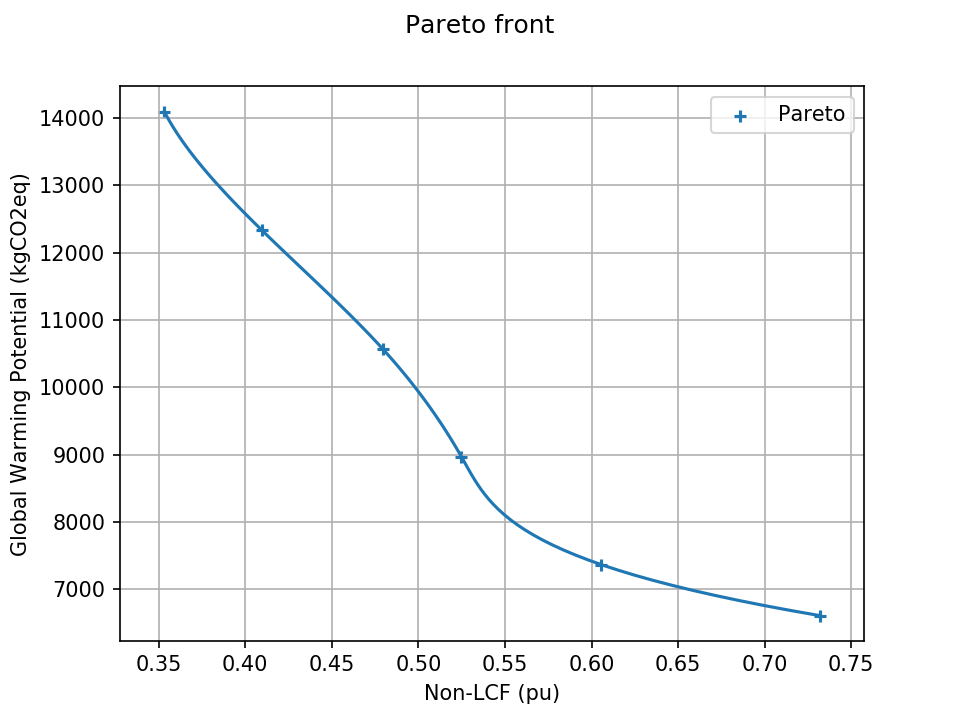

<IPython.core.display.Javascript object>


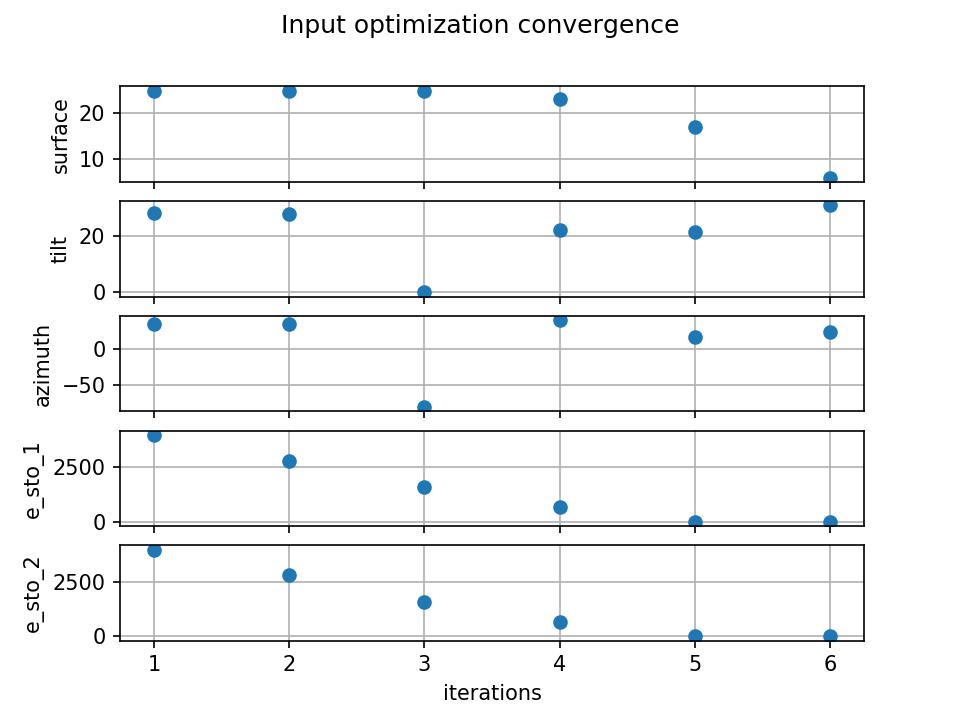

<IPython.core.display.Javascript object>


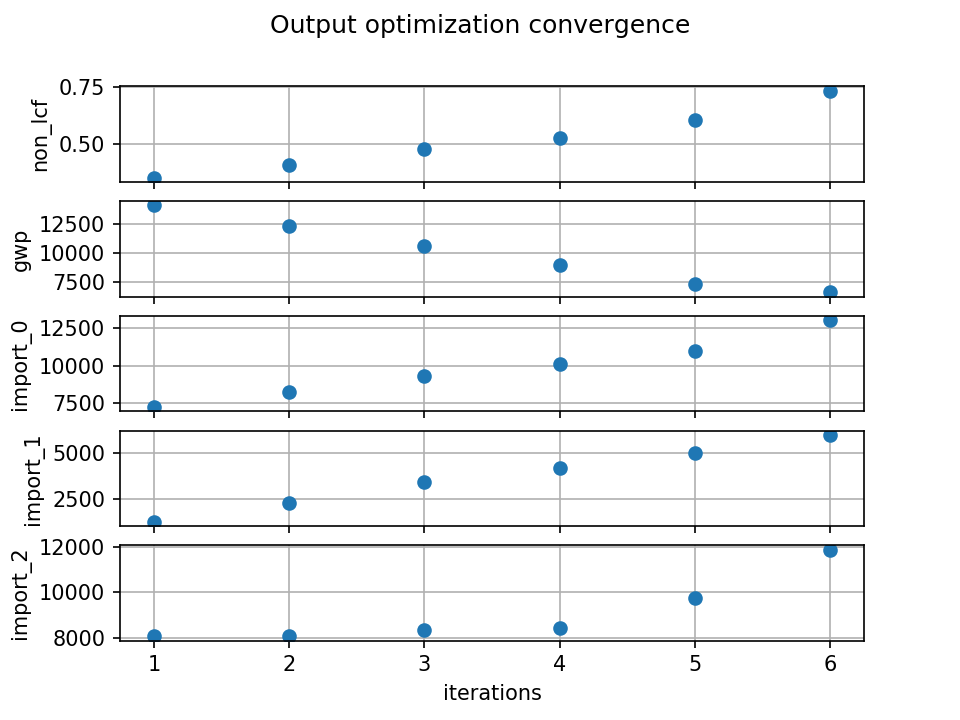

tilt   	 = 22.10885716921261
azimuth   	 = 40.47925449671038
surface   	 = 23.198474520742575
e_sto_1   	 = 678.5406427352921
e_sto_2   	 = 678.5406427195952
e_sto_3   	 = 678.5406366549681
typical_day_nb   	 = 3
typical_day_weight   	 = [50, 180, 135]
nrj   	 = <module 'models.energy' from 'D:\\00 - Eco-SESA\\02 - Outils\\NoLOAD\\noload_benchmarks_open\\examples\\pv_battery_coverage_gwp\\models\\energy.py'>
scf_list   	 = [0.5918174133056163, 0.28466561717571515, 0.9999999999999998]
lcf_list   	 = [0.3368115545518474, 0.6053598102204875, 0.3527377307230698]
import_list   	 = [10126.052307316104, 4185.906045729264, 8448.275464171064]
export_list   	 = [3546.9652312392313, 16135.255059843708, 4.547473508864641e-13]
supply_list   	 = [8689.653470923127, 22556.241454714447, 4604.046392328936]
load_list   	 = [15268.740547000001, 10606.8924406, 13052.321856499999]
coverage_list   	 = [5142.6882396838955, 6420.986394870739, 4604.046392328935]
e_balance_list   	 = [-6579.087076076873, 11949.

In [25]:
pp.plot([resultPareto.resultsHandler], ['Non-LCF (pu)', 'Global Warming '
                                                      'Potential (kgCO2eq)'],
        ['Pareto'], nb_annotation=0, joinDots=True)

resultPareto.plotResults()

for name, value in resultPareto.rawResults.items():
    if not (('irradiance' in name) or ('consumption' in name)):
        print(name, '  \t =', value)

In [26]:
print(resultPareto.resultsHandler.solutions)

[<noload.optimization.iterationHandler.Solution object at 0x000001F9BC14DFD0>, <noload.optimization.iterationHandler.Solution object at 0x000001F9B6574100>, <noload.optimization.iterationHandler.Solution object at 0x000001F9BC0BEAC0>, <noload.optimization.iterationHandler.Solution object at 0x000001F9B6565970>, <noload.optimization.iterationHandler.Solution object at 0x000001F9BAFE0790>, <noload.optimization.iterationHandler.Solution object at 0x000001F9BAFE0430>]


### Interpretation

In [27]:
resultPareto.printResults()

{'surface': 5.791887892342878, 'tilt': 30.70213337026626, 'azimuth': 23.664641303210907, 'e_sto_1': 2.0958668534434748e-21, 'e_sto_2': 3.2347678452134874e-14, 'e_sto_3': 0.0}
{'non_lcf': 0.7318113694908265, 'gwp': 6612.1642528208595, 'import_0': 13029.285047099183, 'import_1': 5980.614961815575, 'import_2': 11887.570869775667, 'export_0': -1.8024454939613884e-21, 'export_1': 1165.0411447282545, 'export_2': 0.0}


A slight bend can be observed when the non-LCF indicator falls below a value of about 0.65. It is noticeable that it is from this point that the capacity of the batteries and the surface area of the PV panels increase both. In addition, the azimuth values here remain relatively constant with a South - South-East orientation, which would therefore be optimal for covering the consumption profiles with PV production.  
It can be seen that in order to maximise the coverage, both the surface of the photovoltaic panels and the battery capacity reach their upper limits to store the PV production of the summer day. The inclination of the panels is 26° and the azimuth equals 28°. Such sizing is intended to maximise the annual producton with no regards for grid exports issues. Smarter sizing could be explored with the non-coverage indicator for instance, maximising the production when its the most needed (in winter) with relevant azimuth and tilt.
For the GWP minimisation objective, the battery capacity is sized at zero, and the PV panels have a surface of 6 m² with an inclination of 31°. This sizing allows PV production to replace imports from the grid as much as possible without the use of batteries, thus falling below 34 tons of CO2 eq. of GWP. A quick calculation allows us to compare this value with that of a GWP without a PV system, which amounts to 40.7 tons of CO2 eq. for 30 years of consumption on the electricity grid alone, with a European mix. This GWP of the grid is also a good indication to situate relatively the GHG emissions of the different sizes presented in the Pareto curve.  

These results are only valid with the GWP assumptions and data presented above. Generally speaking, these results are of course dependent on the input data, assumptions made and modelling choices implemented. 

The results presented here enable to to choose a sizing for the energy system and to look into the battery management. Such study as well as the summary of the complete study including this one is described in the following [OMEGAlpes Jupyter Notebook](https://gricad-gitlab.univ-grenoble-alpes.fr/omegalpes/omegalpes_examples/-/blob/master/notebooks/article_2021_BS_ORUCE.ipynb).

### Limits
The energy model is very simplified: a dynamic calculation of the storage capacity could be carried out to reflect more accurately the operation and management of the storage. This would also make it possible to integrate the dynamics of the network's CO2 emissions and to observe the details of power flows at each time step, thus improving the general understanding of the energy system. Such control could be achieved using MILP linear optimisation techniques.  
In addition, more refined modelling hypotheses could be adopted over the 30 years considered, such as the ageing of batteries and PV panels or the evolution of energy mixes. In addition, part of the consumption profiles could be controlled to reflect a possible adaptation of consumption to local production. A more in-depth study of the clustering results, particularly in terms of distortion of the clusters formed around the centroids, would also make it possible to have a number of centroids adapted for a better representativeness. Finally, it would be interesting to carry out the study at the neighbourhood scale in order to qualify and quantify the consequences on the electricity network, and to evaluate the relevance of the dimensioning with the indicators presented here.  

With regard to the method and data used for LCA, GWP was chosen here because it is an accessible indicator directly linked to climate change, but the consideration of other environmental impacts such as soil and water acidification or the depletion of non-renewable resources would be relevant for a more complete vision. One of the main difficulties concerning open LCA remains the access to data and tools, and the variability of data: on the single GWP indicator of monocrystalline PV panels alone, the differences between values from different reliable sources exceed a factor of 3. In addition to the fact that the calculation of GHG emissions from PV modules depends on a large number of factors, this variability can be explained on the one hand by whether or not connectors and inverters are taken into account in the impact calculation, and on the other hand by the origin of the PV panels as highlighted by *Yue et al, « Domestic and overseas manufacturing scenarios of silicon-based photovoltaics: Life cycle energy and environmental comparative analysis », Solar Energy, vol. 105, p. 669‑678, juill. 2014, doi: 10.1016/j.solener.2014.04.008.*. In this respect, the [BONSAI project's](https://bonsai.uno/) initiative to deploy an open database for LCA data is very relevant and promising.